In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline

In [10]:
# import from pythin packages
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf as xe
import cmocean

# import from pre-built data classes
from data_handler import GEBCO
from plotting_fns import PlottingFns as pfns
from utils import Utils as utls

pfns = pfns()

In [3]:
elevation = GEBCO().ds.elevation

In [4]:
elevation

<xarray.DataArray 'elevation' (latitude: 240, longitude: 2160)>
array([[   36.675   ,    36.675   ,    36.675   , ...,    34.825   ,
           34.825   ,    34.825   ],
       [   60.75    ,    60.75    ,    60.675   , ...,    60.925   ,
           61.      ,    61.      ],
       [  307.65    ,   307.65    ,   307.65375 , ...,   302.831875,
          302.8     ,   302.8     ],
       ...,
       [-4549.12375 , -4663.77375 , -4608.976875, ..., -4420.080625,
        -4428.5075  , -4457.9875  ],
       [-4503.485625, -4537.695   , -4502.979375, ..., -4423.29875 ,
        -4429.2325  , -4431.11    ],
       [-4369.40875 , -4463.49625 , -4468.8225  , ..., -4002.9175  ,
        -4153.53875 , -4305.835625]])
Coordinates:
  * latitude   (latitude) float64 -89.92 -89.75 -89.58 ... -50.42 -50.25 -50.08
  * longitude  (longitude) float64 -179.9 -179.8 -179.6 ... 179.6 179.8 179.9
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [5]:
sice = xr.open_dataset('../Research/data/PROCESSED/nsidc_sea_ice.nc').nsidc_nt_seaice_conc_monthly
regridder = xe.Regridder(sice,elevation,'bilinear')
sice = regridder(sice)
siz = sice.where(sice > 0.15)

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [6]:
sic_cmt = sice.groupby('time.month').mean()
siz_cmt = siz.groupby('time.month').mean()

In [7]:
in_siz = sic_cmt.sel(month=8) > 0.15
in_piz = sice.quantile(0.05,dim='time')>0.15#(sice > 0.15).all(dim='time')
in_miz = in_siz & ~in_piz

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [14]:
def plot_so():
    fig,axs = plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.SouthPolarStereo()})

    pfns.sp(axs,elevation,cbar='Depth (m)',cbar_orientation='vertical',cmap=cmocean.cm.deep_r,bathy=elevation,vmax=0,vmin=-6000)
    axs.contour(sice.longitude.values,sice.latitude.values,sic_cmt.sel(month=8).values,transform=ccrs.PlateCarree(),levels=[0.15],cmap='binary',linewidths=2,vmin=0,vmax=5,linestyles=':')
    axs.contour(sice.longitude.values,sice.latitude.values,sic_cmt.sel(month=1).values,transform=ccrs.PlateCarree(),levels=[0.15],cmap='binary',linewidths=2,vmin=0,vmax=5)
    #axs.contour(sice.longitude.values,sice.latitude.values,sice.quantile(0.05,dim='time').values,transform=ccrs.PlateCarree(),levels=[0.15],cmap='spring',linewidths=2,vmin=0,vmax=5)
    

    lats = [ -60, -67, -69, -72, -63, -64, -66, -67]
    lons = [ -67, -85,-110,-160, 140,  75,   5, -30]
    locs = ['DP','BS','AS','RS','AC','CS','MR','WS']

    for la,lo,lb in zip(lats,lons,locs):    
        axs.text(lo,la,lb,transform=ccrs.PlateCarree(),size=15,c='w',ha='center',bbox=dict(boxstyle="square",facecolor='black',alpha=0.5))

    lons = [ 0, 105, -120]
    lats = [ -60, -57, -60]
    locs = ['W-E Basin','A-A Basin','B-A Basin']

    for la,lo,lb in zip(lats,lons,locs):    
        axs.text(lo,la,lb,transform=ccrs.PlateCarree(),size=13,c='black',ha='center',bbox=dict(boxstyle="square",facecolor='white',alpha=0.5))

    return fig


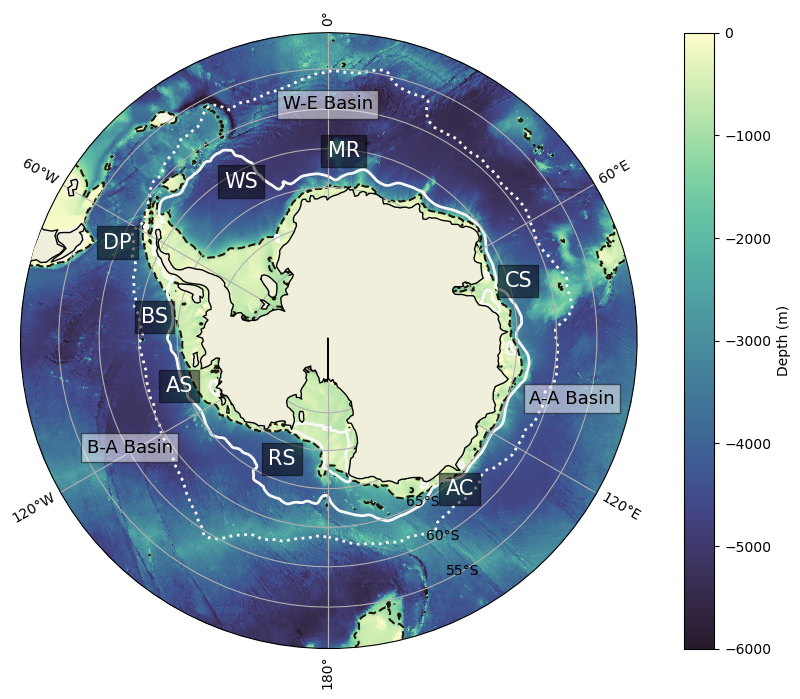

In [15]:
fig = plot_so()
fig.savefig('plots/figure1.png',dpi=200,transparent=True,bbox_inches='tight')

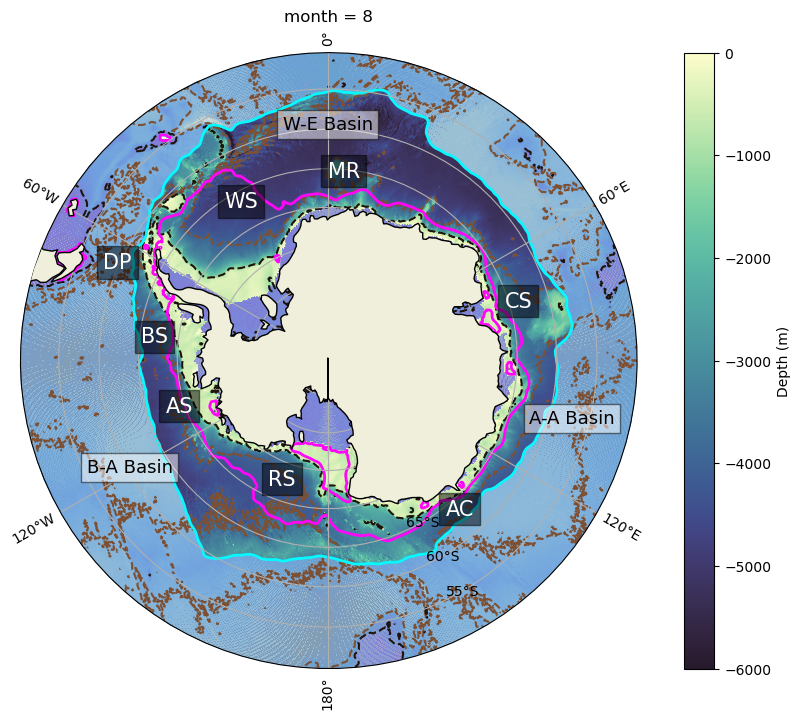

In [15]:
ax_icefree = plot_so()

so_icefree = elevation.where(~in_siz)
so_icefree.plot(ax=ax_icefree,add_colorbar=False,cmap=cmocean.cm.dense,x='longitude',y='latitude',transform=ccrs.PlateCarree(),alpha=0.70)

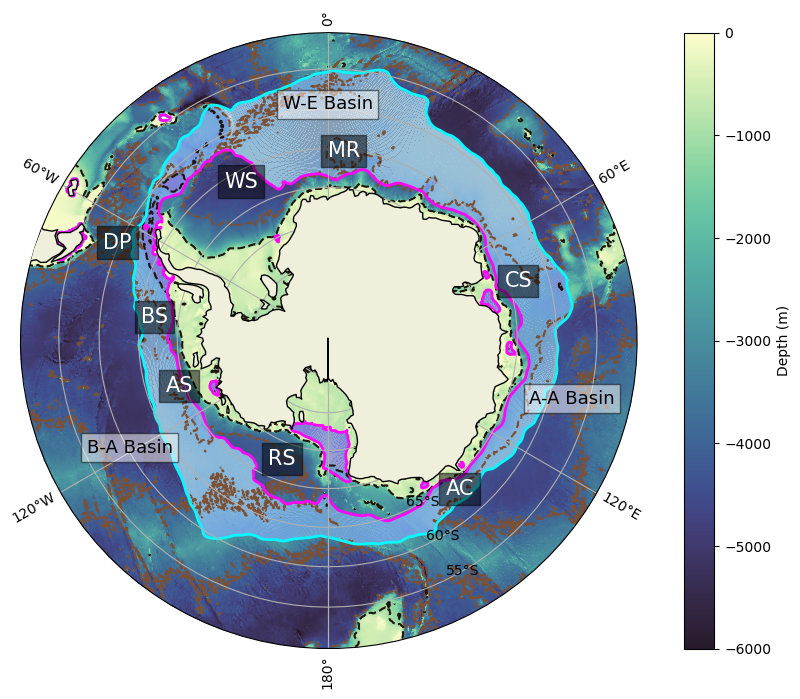

In [21]:
ax_miz = plot_so()

so_miz = elevation.where(in_siz & (sic_cmt.sel(month=1)<0.15))
so_miz.plot(ax=ax_miz,add_colorbar=False,cmap=cmocean.cm.dense,x='longitude',y='latitude',transform=ccrs.PlateCarree(),alpha=0.70)